# Using RandomForestClassification to determine probability of life-threatening adverse events for people over the age of 60

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
%matplotlib inline

In [2]:
# Import our input dataset
vaxsymp = pd.read_csv('../Resources/Data/MLdata.csv')

In [3]:
# Drop age_yrs and convert age_bin to string.
vaxsymp = vaxsymp.drop(columns=['AGE_YRS'])
vaxsymp['AGE_BIN'] = vaxsymp['AGE_BIN'].astype(str)

In [4]:
vaxsymp

,VAERS_ID,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,VAX_MANU,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,AGE_BIN
0,916606,Pharyngeal swelling,0,0,0,0,MODERNA,F,N,N,N,N,N,N,41-60
1,916610,Rash,Urticaria,0,0,0,MODERNA,F,N,N,N,N,N,N,0-18
2,916620,Nausea,Pain in extremity,Pyrexia,0,0,MODERNA,M,N,N,N,N,N,N,61-80+
3,916622,Nausea,0,0,0,0,MODERNA,F,N,N,N,N,N,N,19-40
4,916631,Pain in extremity,0,0,0,0,MODERNA,F,N,N,N,N,N,N,19-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61624,1410344,Dyspnoea,0,0,0,0,PFIZER\BIONTECH,F,N,N,N,N,N,N,0-18
61625,1410353,Chest pain,0,0,0,0,MODERNA,M,N,N,N,N,N,N,41-60
61626,1410362,Pyrexia,0,0,0,0,MODERNA,M,N,N,N,N,N,N,19-40
61627,1410362,Pyrexia,0,0,0,0,MODERNA,M,N,N,N,N,N,N,19-40


In [5]:
vaxsymp['AGE_BIN'].value_counts()

41-60     25412
19-40     20571
61-80+    13854
0-18       1783
nan           9
Name: AGE_BIN, dtype: int64

# Using LabelEncoder to assign unique values to the symptom columns

In [6]:
# Creating LabelEncoder instance
df2 = vaxsymp.copy()
df2[['DIED','ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','AGE_BIN','VAX_MANU','L_THREAT','SEX','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4','SYMPTOM5']] = df2[['DIED','ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','AGE_BIN','VAX_MANU','L_THREAT','SEX','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4','SYMPTOM5']].apply(preprocessing.LabelEncoder().fit_transform)
df2.head(5)

,VAERS_ID,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,VAX_MANU,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,AGE_BIN
0,916606,14,0,0,0,0,1,0,0,0,0,0,0,0,2
1,916610,18,21,0,0,0,1,0,0,0,0,0,0,0,0
2,916620,10,12,15,0,0,1,1,0,0,0,0,0,0,3
3,916622,10,0,0,0,0,1,0,0,0,0,0,0,0,1
4,916631,12,0,0,0,0,1,0,0,0,0,0,0,0,1


In [7]:
# Use OneHotEncoder 
enc = OneHotEncoder(sparse=False)

# Fit and transform using catagorical variable lists
encode_df = pd.DataFrame(enc.fit_transform(df2[['DIED','ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','AGE_BIN','VAX_MANU','L_THREAT','SEX']]))

# Add the names to the list
encode_df.columns = enc.get_feature_names(['DIED','ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','AGE_BIN','VAX_MANU','L_THREAT','SEX'])
encode_df.head(5)

,DIED_0,DIED_1,ER_VISIT_0,ER_VISIT_1,HOSPITAL_0,HOSPITAL_1,DISABLE_0,DISABLE_1,BIRTH_DEFECT_0,BIRTH_DEFECT_1,...,AGE_BIN_4,VAX_MANU_0,VAX_MANU_1,VAX_MANU_2,VAX_MANU_3,L_THREAT_0,L_THREAT_1,SEX_0,SEX_1,SEX_2
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [8]:
# Merge one-hot encoded features and drop the originals
df3 = df2.merge(encode_df, left_index=True, right_index=True)
df3 = df3.drop(columns = ['DIED','ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','AGE_BIN','VAX_MANU','L_THREAT','SEX'])
df3 = df3.set_index(['VAERS_ID']) 
df3.head() 

,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,DIED_0,DIED_1,ER_VISIT_0,ER_VISIT_1,HOSPITAL_0,...,AGE_BIN_4,VAX_MANU_0,VAX_MANU_1,VAX_MANU_2,VAX_MANU_3,L_THREAT_0,L_THREAT_1,SEX_0,SEX_1,SEX_2
VAERS_ID,,,,,,,,,,,,,,,,,,,,,
916606,14,0,0,0,0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
916610,18,21,0,0,0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
916620,10,12,15,0,0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
916622,10,0,0,0,0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
916631,12,0,0,0,0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [9]:
df3['AGE_BIN_3'].value_counts()

0.0    47775
1.0    13854
Name: AGE_BIN_3, dtype: int64

# Use Standard Scaler to scale the data

In [26]:
# drop SYMPTOM1 target from features data
y = df3.AGE_BIN_3
X = df3.drop(columns=['AGE_BIN_0','AGE_BIN_1','AGE_BIN_2','AGE_BIN_3','AGE_BIN_4'])

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Use RandomForestClassifier for our prediction 

In [27]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=42)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.776


In [28]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.79      0.98      0.06      0.87      0.24      0.06     12027
        1.0       0.42      0.06      0.98      0.10      0.24      0.05      3381

avg / total       0.71      0.78      0.26      0.70      0.24      0.06     15408



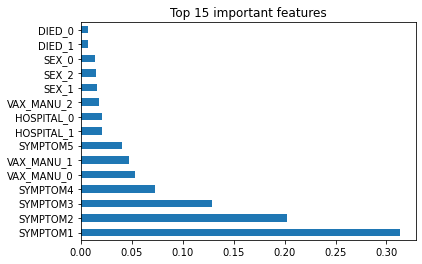

In [29]:
# Visualize the top 15 important features
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [15]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  24
hidden_nodes_layer2 = 12

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=25)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/25
1445/1445 [==============================] - 1s 547us/step - loss: 0.5278 - accuracy: 0.7700
Epoch 2/25
1445/1445 [==============================] - 1s 565us/step - loss: 0.5189 - accuracy: 0.7738
Epoch 3/25
1445/1445 [==============================] - 1s 655us/step - loss: 0.5185 - accuracy: 0.7745
Epoch 4/25
1445/1445 [==============================] - 1s 683us/step - loss: 0.5179 - accuracy: 0.7745
Epoch 5/25
1445/1445 [==============================] - 1s 565us/step - loss: 0.5177 - accuracy: 0.7743
Epoch 6/25
1445/1445 [==============================] - 1s 613us/step - loss: 0.5178 - accuracy: 0.7743
Epoch 7/25
1445/1445 [==============================] - 1s 562us/step - loss: 0.5174 - accuracy: 0.7745
Epoch 8/25
1445/1445 [==============================] - 1s 668us/step - loss: 0.5175 - accuracy: 0.7743
Epoch 9/25
1445/1445 [==============================] - 1s 680us/step - loss: 0.5172 - accuracy: 0.7744
Epoch 10/25
1445/1445 [==============================] - 1s 573u